In [37]:
#Import packages
import pandas as pd
import numpy as np
import glob

from functions import plotting_raw_data, remove_outliers, error_plot, plot_cpt_data, plot_cpt_data_ML_prediction, plot_cpt_data_NW_site

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_param_importances, plot_optimization_history

In [38]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
cm = 1/2.54  # centimeters in inches

In [39]:
# =============================================================================
# Import Dataset
# =============================================================================
path = r"..\data\soil_parameter\\"
file_list =  glob.glob(path + "/*.xlsx")
data_list = []
 
for file in file_list:
    data_list.append(pd.read_excel(file, sheet_name=0))

data_merged = pd.concat(data_list, ignore_index=True)

In [40]:
data_merged

,sampling_name (-),sampling_depth (m),sampling_corr_depth (m),sampling_unitweight (kN/m3),sampling_Oed_type (-),sampling_M (MN/m2),sampling_OCR (-),sampling_Strength_type (-),sampling_su (kN/m2),cptu_name (-),...,"Corr_OCR (qt, Kulhawy&Mayne 1990)","Corr_OCR (qt&Ic, Mayne 2009)","Corr_OCR (Bq, Chen&Mayne 1996)","Corr_su (Nkt, Lunne 2005)","Corr_su (Nke, Mayne 2008)","Corr_su (Ndeltau, Lunne 2010)",Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 35
0,Project_Norway_N11036,4.43,4.43,19.750000,CRS,NaN,NaN,NaN,NaN,CPTuN11036,...,2.816603,2.174446,1.618336,42.025000,29.723125,54.266667,NaN,Nkt,12.0,NaN
1,Project_Norway_N11036,7.50,7.50,19.700000,CRS,NaN,NaN,NaN,NaN,CPTuN11036,...,1.619397,1.430463,1.224095,36.088833,19.302000,61.150000,NaN,Nke,8.0,NaN
2,Project_Norway_N11036,10.37,10.37,19.330000,CRS,5.500000,1.390000,NaN,NaN,CPTuN11036,...,1.392491,1.341905,1.155392,40.619583,21.052083,72.422222,NaN,Ndeltau,6.0,NaN
3,Project_Norway_N11036,13.53,13.53,19.610000,CRS,6.500000,1.300000,NaN,NaN,CPTuN11036,...,1.373177,1.337369,1.452623,50.465972,39.155417,72.980556,NaN,NaN,NaN,NaN
4,Project_Norway_N11036,16.56,16.56,19.460000,CRS,9.500000,1.560000,NaN,NaN,CPTuN11036,...,1.184070,1.162875,1.345153,52.123000,39.234500,80.986667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,PTS_Seekirchen_CC12,4.40,4.55,17.849941,IL,2.203390,2.058824,NaN,NaN,SeekirchenCPTu1,...,2.720101,2.417730,1.716886,35.910833,26.900000,44.668333,NaN,NaN,NaN,NaN
603,PTS_Seekirchen_CC12,4.40,4.55,16.930067,CRS,1.950510,2.156863,NaN,NaN,SeekirchenCPTu1,...,2.720101,2.417730,1.716886,35.910833,26.900000,44.668333,NaN,NaN,NaN,NaN
604,PTS_Seekirchen_CC12,4.40,4.55,16.900000,NaN,NaN,NaN,NaN,NaN,SeekirchenCPTu1,...,2.720101,2.417730,1.716886,35.910833,26.900000,44.668333,NaN,NaN,NaN,NaN
605,PTS_Seekirchen_CC32,4.40,4.65,17.237443,IL,2.076677,1.960784,NaN,NaN,SeekirchenCPTu1,...,2.733672,2.428894,1.747218,36.600833,27.650000,45.171667,NaN,NaN,NaN,NaN


,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa),sampling_name(-)
0,4.43,0.537750,5.383333,0.918270,352.900000,19.750000,NaN,NaN,NaN,Project_Norway_N11036
1,7.50,0.515580,2.260000,0.390734,424.900000,19.700000,NaN,NaN,NaN,Project_Norway_N11036
2,10.37,0.611467,4.633333,0.674628,521.233333,19.330000,5.500000,1.390000,NaN,Project_Norway_N11036
3,13.53,0.786000,7.366667,0.852065,556.183333,19.610000,6.500000,1.300000,NaN,Project_Norway_N11036
4,16.56,0.853220,7.240000,0.764968,634.520000,19.460000,9.500000,1.560000,NaN,Project_Norway_N11036
...,...,...,...,...,...,...,...,...,...,...
553,12.90,0.690000,9.500000,1.280000,372.500000,17.576633,3.342717,1.013250,NaN,PITS_Rhesi_KB02
554,12.90,0.690000,9.500000,1.280000,372.500000,17.924784,NaN,NaN,NaN,PITS_Rhesi_KB02
555,12.90,0.690000,9.500000,1.280000,372.500000,17.924784,4.504654,1.208106,NaN,PITS_Rhesi_KB02
594,4.80,0.480000,8.800000,1.670000,310.500000,17.924784,0.902065,NaN,NaN,PITS_Seekirchen_BS01


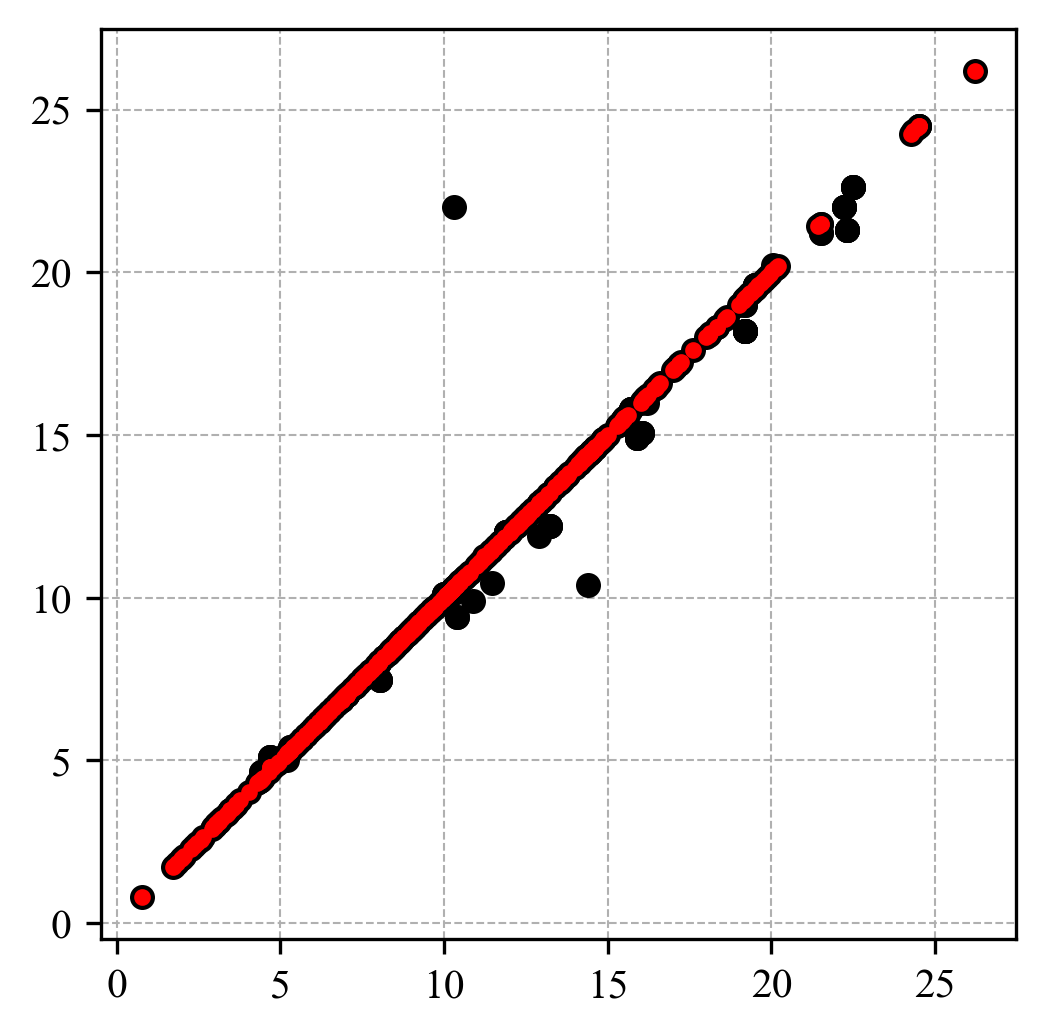

In [41]:
# # Select columns
selected_columns = ['sampling_name (-)','sampling_depth (m)','cptu_depth (m)','cptu_corr_depth (m)', 'cptu_qc (MPa)', 'cptu_fs (kPa)',
       'cptu_u2 (kPa)', 'cptu_Rf (%)',  'cptu_SBT', 'sampling_unitweight (kN/m3)','sampling_M (MN/m2)', 'sampling_OCR (-)', 'sampling_su (kN/m2)'] 

data = data_merged[selected_columns]
mismatch_1_2 = data[data['sampling_depth (m)'] != data['cptu_depth (m)']]

# Filter rows where the absolute difference is within 0.1m
filtered_data = data[abs(data['sampling_depth (m)'] - data['cptu_depth (m)']) <= 0.1]

plt.figure(dpi = 300, figsize = (10*cm,10*cm))
plt.plot(data['sampling_depth (m)'], data['cptu_depth (m)'], 'o', markersize = 5, color = 'black')
plt.plot(filtered_data['sampling_depth (m)'], filtered_data['cptu_depth (m)'], 'o', color = 'red', markersize = 3)
plt.grid(lw = 0.5, ls = '--')

selected_columns = ['cptu_depth (m)', 'cptu_qc (MPa)', 'cptu_fs (kPa)', 'cptu_Rf (%)', 'cptu_u2 (kPa)', 'sampling_unitweight (kN/m3)','sampling_M (MN/m2)', 'sampling_OCR (-)', 'sampling_su (kN/m2)', 'sampling_name (-)'] 
renamed_columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)','u2 (kPa)', 'gamma (kN/m3)', 'M (MN/m2)', 'OCR (-)', 'su (kPa)', 'sampling_name(-)'] #for Machine learning features
data_ML = filtered_data[selected_columns]
data_ML.columns = renamed_columns_x


In [1]:
data_ML.loc[:,'Rf (%)'] = data_ML.loc[:,'fs (kPa)']/(data_ML.loc[:,'qc (MPa)']*1000)*100
data_ML.to_csv(r'..\data\database_preprocessed.csv', index = False)
data_ML

NameError: name 'data_ML' is not defined